# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c journey-springfield

 98%|████████████████████████████████████████▏| 511M/521M [00:04<00:00, 136MB/s]
100%|█████████████████████████████████████████| 521M/521M [00:04<00:00, 120MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('/kaggle/working/journey-springfield.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/journey-springfield/')

In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
import PIL
print(PIL.__version__)

9.5.0


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Mar 11 13:13:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              28W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import time

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

RANDOM_STATE= 42

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, data_augmentation=False):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        
        self.data_augmentation = data_augmentation

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(RESCALE_SIZE),
            transforms.RandomHorizontalFlip(),
            base_transform
        ])
        
        test_transform = transforms.Compose([
            transforms.Resize(RESCALE_SIZE),
            transforms.CenterCrop(RESCALE_SIZE),
            base_transform
        ])
        
        transform = {
            'train': train_transform,
            'test': test_transform,
            'val': test_transform
        }
            
        x = self.load_sample(self.files[index])
        if self.data_augmentation:
            x = transform[self.mode](x)
        else:
            x = test_transform(x)
            
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/working/journey-springfield/train')
TEST_DIR = Path('/kaggle/working/journey-springfield/testset')

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [14]:
len(train_files), len(val_files)

(16746, 4187)

In [15]:
pd.DataFrame(train_val_labels).value_counts().sort_values()

0                       
lionel_hutz                    3
disco_stu                      8
troy_mcclure                   8
miss_hoover                   17
fat_tony                      27
gil                           27
otto_mann                     32
sideshow_mel                  40
agnes_skinner                 42
rainier_wolfcastle            45
cletus_spuckler               47
snake_jailbird                55
professor_john_frink          65
martin_prince                 71
patty_bouvier                 72
ralph_wiggum                  89
carl_carlson                  98
selma_bouvier                103
barney_gumble                106
groundskeeper_willie         121
maggie_simpson               128
waylon_smithers              181
mayor_quimby                 246
lenny_leonard                310
nelson_muntz                 358
edna_krabappel               457
comic_book_guy               469
kent_brockman                498
apu_nahasapeemapetilon       623
sideshow_bob      

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

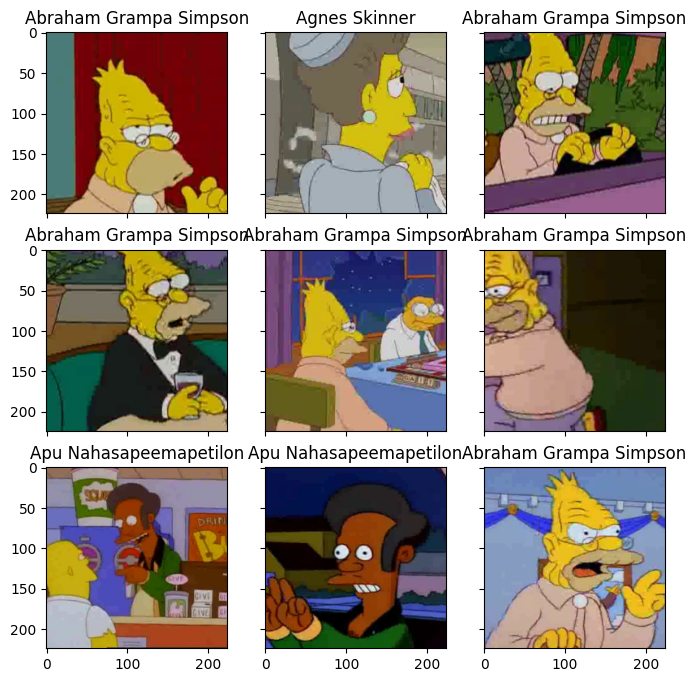

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

**With padding = 1:**
1. размерность входа: 3x224x224
2.размерности после слоя:  8x112x112
3. 16x56x56
4. 32x28x28
5. 64x14x14
6. выход: 96x7x7

In [16]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 7 * 7, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [17]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [20]:
def train(
    train_files,
    val_files,
    model,
    criterion,
    optimizer,
    scheduler,
    epochs,
    batch_size
):
    since = time.time()
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    best_val_acc = 0.0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            best_val_acc = max(best_val_acc, val_acc)
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_val_acc))
    return history

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

### SimpleCnn

In [23]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
params = count_parameters(simple_cnn)
print("we will classify: {}".format(n_classes))
print("we have parameters: {}\n".format(params))
print(simple_cnn)

we will classify: 42
we have parameters: 277962

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stri

In [31]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

In [33]:
history = train(
    train_files=train_dataset,
    val_files=val_dataset,
    model=simple_cnn,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    epochs=20,
    batch_size=32
)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.0796532377780417


epoch:   5%|▌         | 1/20 [00:55<17:34, 55.50s/it]


Epoch 001 train_loss: 2.0797     val_loss 1.4592 train_acc 0.4716 val_acc 0.6186
loss 1.0979442230678154


epoch:  10%|█         | 2/20 [01:49<16:23, 54.66s/it]


Epoch 002 train_loss: 1.0979     val_loss 0.9732 train_acc 0.6989 val_acc 0.7385
loss 0.6995510457736054


epoch:  15%|█▌        | 3/20 [02:44<15:30, 54.72s/it]


Epoch 003 train_loss: 0.6996     val_loss 0.8449 train_acc 0.8050 val_acc 0.7803
loss 0.4554700908959303


epoch:  20%|██        | 4/20 [03:39<14:35, 54.69s/it]


Epoch 004 train_loss: 0.4555     val_loss 0.8597 train_acc 0.8684 val_acc 0.7944
loss 0.2882924733567121


epoch:  25%|██▌       | 5/20 [04:33<13:40, 54.67s/it]


Epoch 005 train_loss: 0.2883     val_loss 0.7927 train_acc 0.9142 val_acc 0.8187
loss 0.19837816028979094


epoch:  30%|███       | 6/20 [05:28<12:44, 54.61s/it]


Epoch 006 train_loss: 0.1984     val_loss 0.9362 train_acc 0.9380 val_acc 0.8077
loss 0.05921787199386645


epoch:  35%|███▌      | 7/20 [06:22<11:49, 54.54s/it]


Epoch 007 train_loss: 0.0592     val_loss 1.0038 train_acc 0.9823 val_acc 0.8302
loss 0.019629918449892782


epoch:  40%|████      | 8/20 [07:17<10:54, 54.52s/it]


Epoch 008 train_loss: 0.0196     val_loss 1.1819 train_acc 0.9948 val_acc 0.8414
loss 0.031138598639757164


epoch:  45%|████▌     | 9/20 [08:10<09:57, 54.28s/it]


Epoch 009 train_loss: 0.0311     val_loss 1.0931 train_acc 0.9916 val_acc 0.8297
loss 0.03593525891238417


epoch:  50%|█████     | 10/20 [09:05<09:02, 54.27s/it]


Epoch 010 train_loss: 0.0359     val_loss 1.2755 train_acc 0.9891 val_acc 0.8347
loss 0.0384811743110823


epoch:  55%|█████▌    | 11/20 [09:59<08:08, 54.31s/it]


Epoch 011 train_loss: 0.0385     val_loss 1.1827 train_acc 0.9875 val_acc 0.8266
loss 0.032548594602973074


epoch:  60%|██████    | 12/20 [10:53<07:13, 54.22s/it]


Epoch 012 train_loss: 0.0325     val_loss 1.1860 train_acc 0.9891 val_acc 0.8335
loss 0.00580544303788958


epoch:  65%|██████▌   | 13/20 [11:47<06:19, 54.27s/it]


Epoch 013 train_loss: 0.0058     val_loss 1.2598 train_acc 0.9986 val_acc 0.8457
loss 0.0010637135541700803


epoch:  70%|███████   | 14/20 [12:42<05:26, 54.40s/it]


Epoch 014 train_loss: 0.0011     val_loss 1.2843 train_acc 0.9998 val_acc 0.8519
loss 0.0006046858199026076


epoch:  75%|███████▌  | 15/20 [13:37<04:32, 54.56s/it]


Epoch 015 train_loss: 0.0006     val_loss 1.3452 train_acc 0.9999 val_acc 0.8560
loss 0.0005712633506324862


epoch:  80%|████████  | 16/20 [14:31<03:37, 54.45s/it]


Epoch 016 train_loss: 0.0006     val_loss 1.3566 train_acc 0.9999 val_acc 0.8557
loss 0.0004947275219547216


epoch:  85%|████████▌ | 17/20 [15:26<02:43, 54.64s/it]


Epoch 017 train_loss: 0.0005     val_loss 1.4092 train_acc 0.9998 val_acc 0.8548
loss 0.0004295030654982471


epoch:  90%|█████████ | 18/20 [16:21<01:49, 54.55s/it]


Epoch 018 train_loss: 0.0004     val_loss 1.4315 train_acc 0.9999 val_acc 0.8543
loss 0.0003208969164060118


epoch:  95%|█████████▌| 19/20 [17:15<00:54, 54.56s/it]


Epoch 019 train_loss: 0.0003     val_loss 1.4596 train_acc 0.9999 val_acc 0.8550
loss 0.00023448590684007972


epoch: 100%|██████████| 20/20 [18:09<00:00, 54.48s/it]


Epoch 020 train_loss: 0.0002     val_loss 1.4906 train_acc 0.9999 val_acc 0.8548
Training complete in 18m 10s
Best val acc: 0.855983


In [24]:
def plot_history(param, history):
    train_loss, train_acc, val_loss, val_acc = zip(*history)
    
    history_map = {
        "accuracy": (train_acc, val_acc),
        "loss": (train_loss, val_loss)
    }
    
    plt.figure(figsize=(15, 9))
    plt.plot(history_map[param][0], label='train')
    plt.plot(history_map[param][1], label='val')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel(param)
    plt.title(f"{param} history")
    plt.grid()
    plt.show()

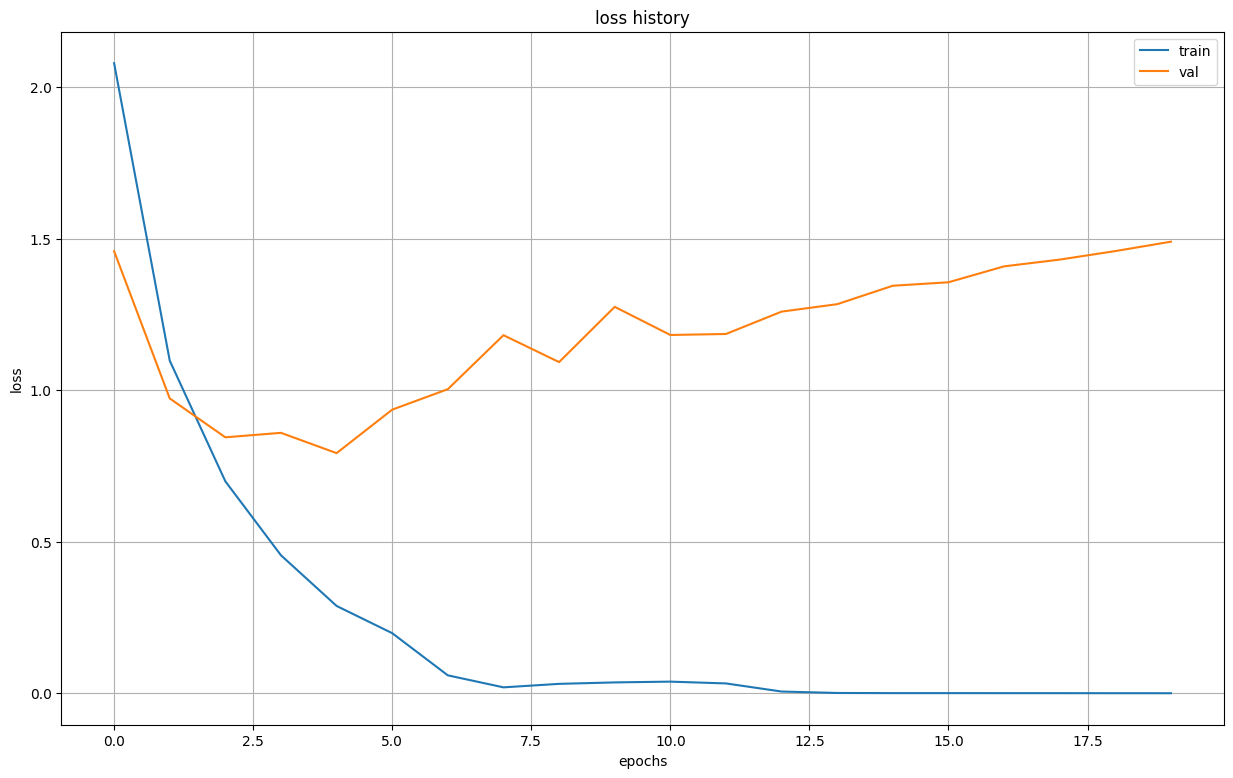

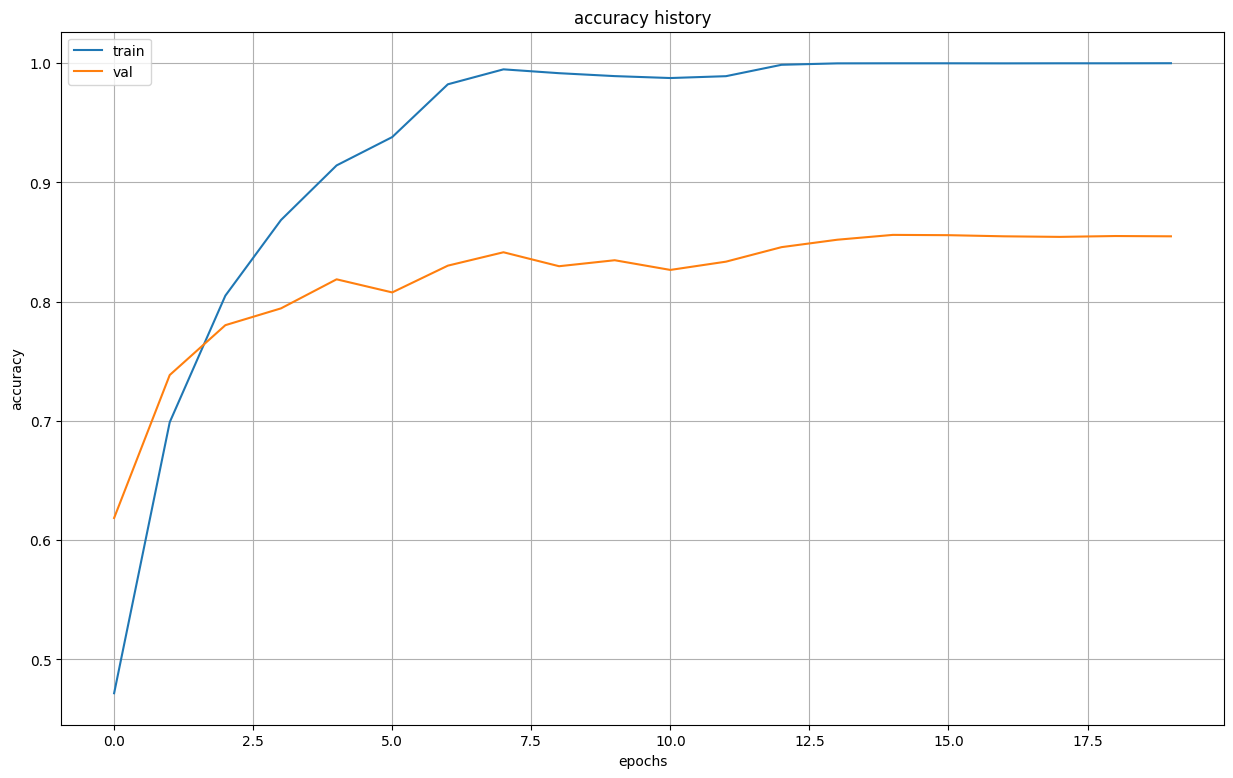

In [35]:
plot_history("loss", history)
plot_history("accuracy", history)

In [25]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [26]:
def evaluate_f1(val_dataset, model_cnn):
    np.random.seed(RANDOM_STATE)
    idxs = list(map(int, np.random.choice(len(val_dataset), round(len(val_dataset) * 0.5), replace=False)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model_cnn, imgs)
    
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [val_dataset[id][1] for id in idxs]
    preds_class = [label_encoder.classes_[i] for i in y_pred]
    
    f1 = f1_score(actual_labels, y_pred, average='micro')
    return f1

In [39]:
f1 = evaluate_f1(val_dataset, simple_cnn)
print(f'F1 = {f1:.4f}')

F1 = 0.8634


### SimpleCnn with data augmentation

In [40]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

In [41]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val', data_augmentation=True)

train_dataset = SimpsonsDataset(train_files, mode='train', data_augmentation=True)

In [42]:
history_augm = train(
    train_files=train_dataset,
    val_files=val_dataset,
    model=simple_cnn,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    epochs=20,
    batch_size=32
)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.6969055689521606


epoch:   5%|▌         | 1/20 [00:50<15:56, 50.34s/it]


Epoch 001 train_loss: 2.6969     val_loss 1.8815 train_acc 0.2859 val_acc 0.5061
loss 2.1604234713544472


epoch:  10%|█         | 2/20 [01:40<15:08, 50.47s/it]


Epoch 002 train_loss: 2.1604     val_loss 1.4868 train_acc 0.4111 val_acc 0.5856
loss 1.8045596121659662


epoch:  15%|█▌        | 3/20 [02:31<14:19, 50.58s/it]


Epoch 003 train_loss: 1.8046     val_loss 1.1772 train_acc 0.5109 val_acc 0.6761
loss 1.568605893247375


epoch:  20%|██        | 4/20 [03:22<13:31, 50.74s/it]


Epoch 004 train_loss: 1.5686     val_loss 0.9878 train_acc 0.5689 val_acc 0.7294
loss 1.4287444433402263


epoch:  25%|██▌       | 5/20 [04:13<12:40, 50.69s/it]


Epoch 005 train_loss: 1.4287     val_loss 0.8889 train_acc 0.6126 val_acc 0.7559
loss 1.3251809484284083


epoch:  30%|███       | 6/20 [05:03<11:49, 50.71s/it]


Epoch 006 train_loss: 1.3252     val_loss 0.7779 train_acc 0.6354 val_acc 0.7908
loss 1.1531417535707598


epoch:  35%|███▌      | 7/20 [05:54<11:00, 50.81s/it]


Epoch 007 train_loss: 1.1531     val_loss 0.6895 train_acc 0.6876 val_acc 0.8139
loss 1.1206416424408787


epoch:  40%|████      | 8/20 [06:46<10:11, 50.98s/it]


Epoch 008 train_loss: 1.1206     val_loss 0.6820 train_acc 0.6934 val_acc 0.8180
loss 1.0641283445584366


epoch:  45%|████▌     | 9/20 [07:37<09:20, 51.00s/it]


Epoch 009 train_loss: 1.0641     val_loss 0.6841 train_acc 0.7092 val_acc 0.8218
loss 1.0533317838335328


epoch:  50%|█████     | 10/20 [08:28<08:31, 51.11s/it]


Epoch 010 train_loss: 1.0533     val_loss 0.5955 train_acc 0.7141 val_acc 0.8414
loss 1.0134104953830307


epoch:  55%|█████▌    | 11/20 [09:19<07:39, 51.04s/it]


Epoch 011 train_loss: 1.0134     val_loss 0.5820 train_acc 0.7225 val_acc 0.8428
loss 0.9792236998333778


epoch:  60%|██████    | 12/20 [10:10<06:48, 51.07s/it]


Epoch 012 train_loss: 0.9792     val_loss 0.5710 train_acc 0.7319 val_acc 0.8471
loss 0.9056497011349276


epoch:  65%|██████▌   | 13/20 [11:02<05:59, 51.30s/it]


Epoch 013 train_loss: 0.9056     val_loss 0.5281 train_acc 0.7543 val_acc 0.8620
loss 0.8853611148814637


epoch:  70%|███████   | 14/20 [11:53<05:07, 51.30s/it]


Epoch 014 train_loss: 0.8854     val_loss 0.5408 train_acc 0.7568 val_acc 0.8586
loss 0.8729647546348129


epoch:  75%|███████▌  | 15/20 [12:44<04:15, 51.19s/it]


Epoch 015 train_loss: 0.8730     val_loss 0.5170 train_acc 0.7632 val_acc 0.8672
loss 0.8582022164502366


epoch:  80%|████████  | 16/20 [13:35<03:24, 51.18s/it]


Epoch 016 train_loss: 0.8582     val_loss 0.5157 train_acc 0.7629 val_acc 0.8682
loss 0.8606499599952019


epoch:  85%|████████▌ | 17/20 [14:26<02:33, 51.12s/it]


Epoch 017 train_loss: 0.8606     val_loss 0.4988 train_acc 0.7687 val_acc 0.8708
loss 0.8600196706683465


epoch:  90%|█████████ | 18/20 [15:18<01:42, 51.11s/it]


Epoch 018 train_loss: 0.8600     val_loss 0.5201 train_acc 0.7645 val_acc 0.8629
loss 0.8137864271087856


epoch:  95%|█████████▌| 19/20 [16:08<00:50, 50.94s/it]


Epoch 019 train_loss: 0.8138     val_loss 0.4828 train_acc 0.7808 val_acc 0.8729
loss 0.7891658599069437


epoch: 100%|██████████| 20/20 [16:59<00:00, 50.97s/it]


Epoch 020 train_loss: 0.7892     val_loss 0.4684 train_acc 0.7851 val_acc 0.8784
Training complete in 16m 59s
Best val acc: 0.878433


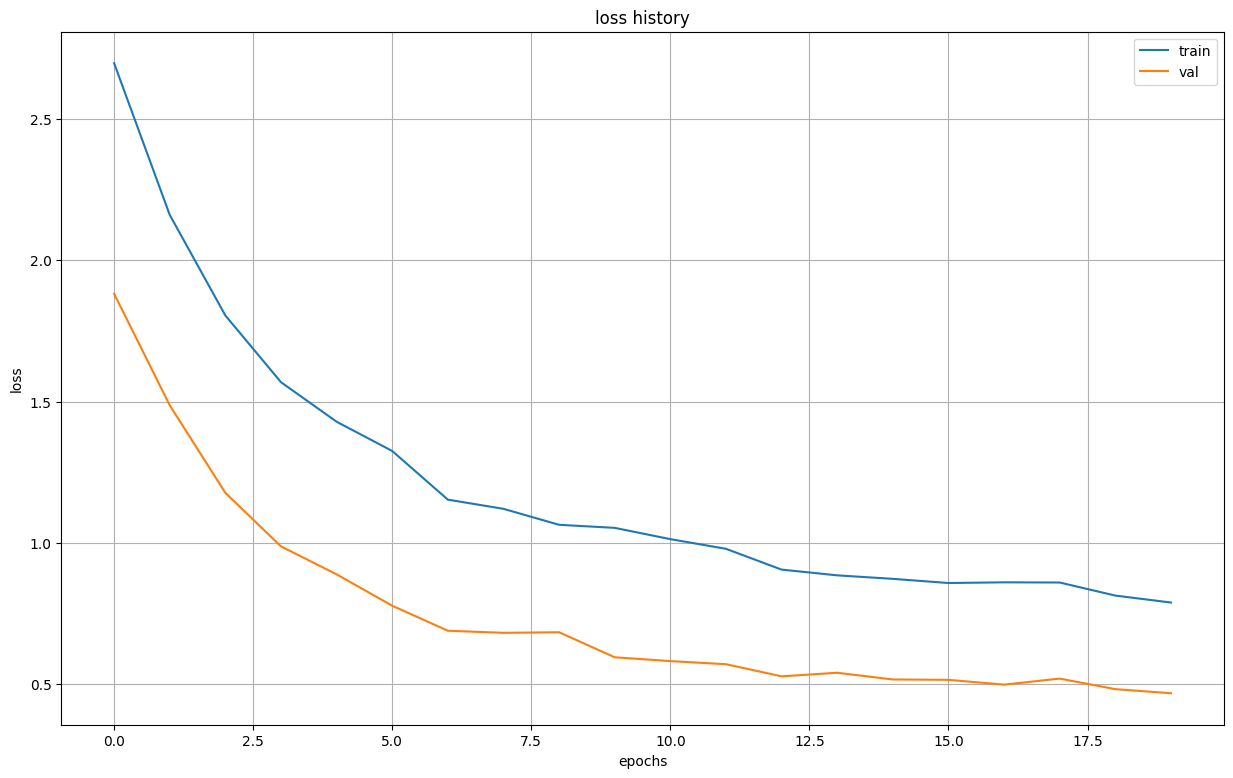

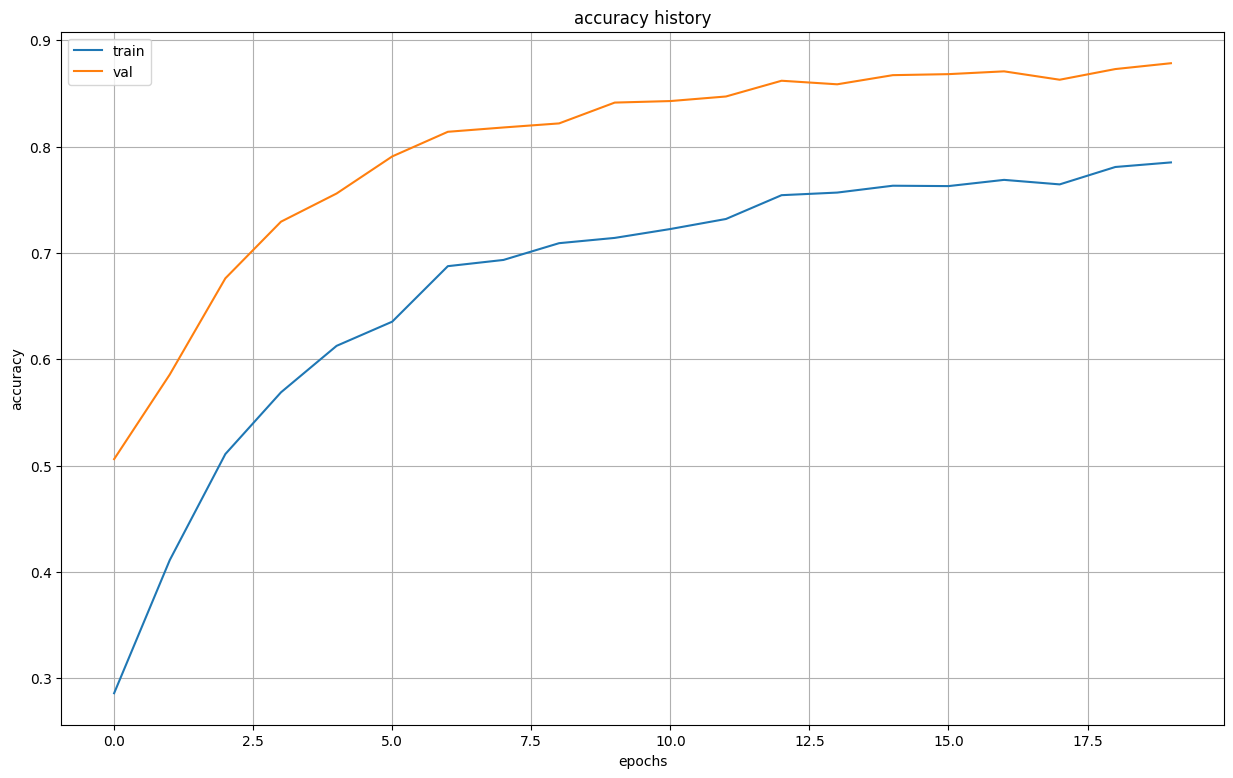

In [43]:
plot_history("loss", history_augm)
plot_history("accuracy", history_augm)

In [45]:
f1 = evaluate_f1(val_dataset, simple_cnn)
print(f'F1 = {f1:.4f}')

F1 = 0.8763


### ResNet as feature extractor

In [27]:
model_resnet50 = models.resnet50(weights='IMAGENET1K_V1')

for param in model_resnet50.parameters():
    param.require_grad = False

num_features = model_resnet50.fc.in_features
model_resnet50.fc = torch.nn.Linear(num_features, n_classes)
model_resnet50 = model_resnet50.to(DEVICE)

optimizer = torch.optim.Adam(model_resnet50.fc.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

In [50]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train', data_augmentation=True)

In [51]:
history_resnet = train(
    train_files=train_dataset,
    val_files=val_dataset,
    model=model_resnet50,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    epochs=20,
    batch_size=32
)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.170361565601067


epoch:   5%|▌         | 1/20 [01:43<32:38, 103.07s/it]


Epoch 001 train_loss: 2.1704     val_loss 1.4070 train_acc 0.4378 val_acc 0.6429
loss 1.5903993624734234


epoch:  10%|█         | 2/20 [03:24<30:33, 101.84s/it]


Epoch 002 train_loss: 1.5904     val_loss 1.1341 train_acc 0.5748 val_acc 0.7034
loss 1.4583501793229707


epoch:  15%|█▌        | 3/20 [05:04<28:42, 101.33s/it]


Epoch 003 train_loss: 1.4584     val_loss 1.0427 train_acc 0.6091 val_acc 0.7177
loss 1.3815875066788865


epoch:  20%|██        | 4/20 [06:45<26:56, 101.04s/it]


Epoch 004 train_loss: 1.3816     val_loss 1.0614 train_acc 0.6259 val_acc 0.7101
loss 1.3511046233263178


epoch:  25%|██▌       | 5/20 [08:25<25:12, 100.82s/it]


Epoch 005 train_loss: 1.3511     val_loss 1.0599 train_acc 0.6347 val_acc 0.7077
loss 1.3160642385909909


epoch:  30%|███       | 6/20 [10:06<23:30, 100.76s/it]


Epoch 006 train_loss: 1.3161     val_loss 0.9581 train_acc 0.6457 val_acc 0.7394
loss 1.2092570385795673


epoch:  35%|███▌      | 7/20 [11:47<21:50, 100.81s/it]


Epoch 007 train_loss: 1.2093     val_loss 0.8907 train_acc 0.6704 val_acc 0.7590
loss 1.193384555225288


epoch:  40%|████      | 8/20 [13:27<20:08, 100.75s/it]


Epoch 008 train_loss: 1.1934     val_loss 0.8776 train_acc 0.6725 val_acc 0.7619
loss 1.1835134532251452


epoch:  45%|████▌     | 9/20 [15:08<18:26, 100.60s/it]


Epoch 009 train_loss: 1.1835     val_loss 0.8676 train_acc 0.6752 val_acc 0.7659
loss 1.1632300356760483


epoch:  50%|█████     | 10/20 [16:49<16:46, 100.67s/it]


Epoch 010 train_loss: 1.1632     val_loss 0.8351 train_acc 0.6833 val_acc 0.7686
loss 1.1755680035736118


epoch:  55%|█████▌    | 11/20 [18:29<15:05, 100.60s/it]


Epoch 011 train_loss: 1.1756     val_loss 0.8396 train_acc 0.6750 val_acc 0.7762
loss 1.150124531385649


epoch:  60%|██████    | 12/20 [20:10<13:25, 100.69s/it]


Epoch 012 train_loss: 1.1501     val_loss 0.8171 train_acc 0.6857 val_acc 0.7772
loss 1.1074709451911868


epoch:  65%|██████▌   | 13/20 [21:51<11:45, 100.85s/it]


Epoch 013 train_loss: 1.1075     val_loss 0.7923 train_acc 0.7006 val_acc 0.7839
loss 1.1039325366748585


epoch:  70%|███████   | 14/20 [23:32<10:06, 101.00s/it]


Epoch 014 train_loss: 1.1039     val_loss 0.7869 train_acc 0.7012 val_acc 0.7860
loss 1.081701213835417


epoch:  75%|███████▌  | 15/20 [25:13<08:24, 100.90s/it]


Epoch 015 train_loss: 1.0817     val_loss 0.7884 train_acc 0.7048 val_acc 0.7884
loss 1.0814244540008495


epoch:  80%|████████  | 16/20 [26:54<06:43, 100.89s/it]


Epoch 016 train_loss: 1.0814     val_loss 0.7838 train_acc 0.7015 val_acc 0.7862
loss 1.080709902784324


epoch:  85%|████████▌ | 17/20 [28:35<05:02, 100.86s/it]


Epoch 017 train_loss: 1.0807     val_loss 0.7714 train_acc 0.7033 val_acc 0.7958
loss 1.077209174355398


epoch:  90%|█████████ | 18/20 [30:16<03:22, 101.02s/it]


Epoch 018 train_loss: 1.0772     val_loss 0.7642 train_acc 0.7049 val_acc 0.7975
loss 1.051893770730326


epoch:  95%|█████████▌| 19/20 [31:57<01:41, 101.00s/it]


Epoch 019 train_loss: 1.0519     val_loss 0.7597 train_acc 0.7164 val_acc 0.7944
loss 1.0653734256556908


epoch: 100%|██████████| 20/20 [33:38<00:00, 100.93s/it]


Epoch 020 train_loss: 1.0654     val_loss 0.7506 train_acc 0.7131 val_acc 0.7991
Training complete in 33m 39s
Best val acc: 0.799140


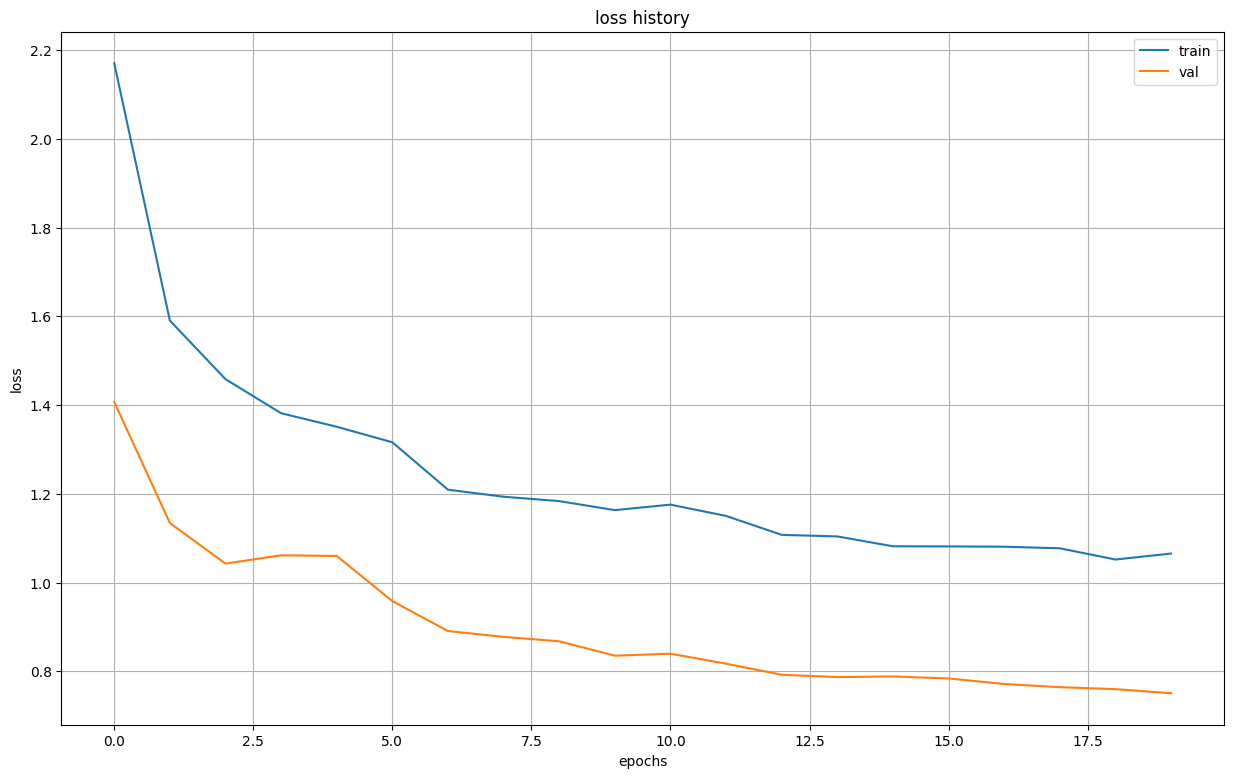

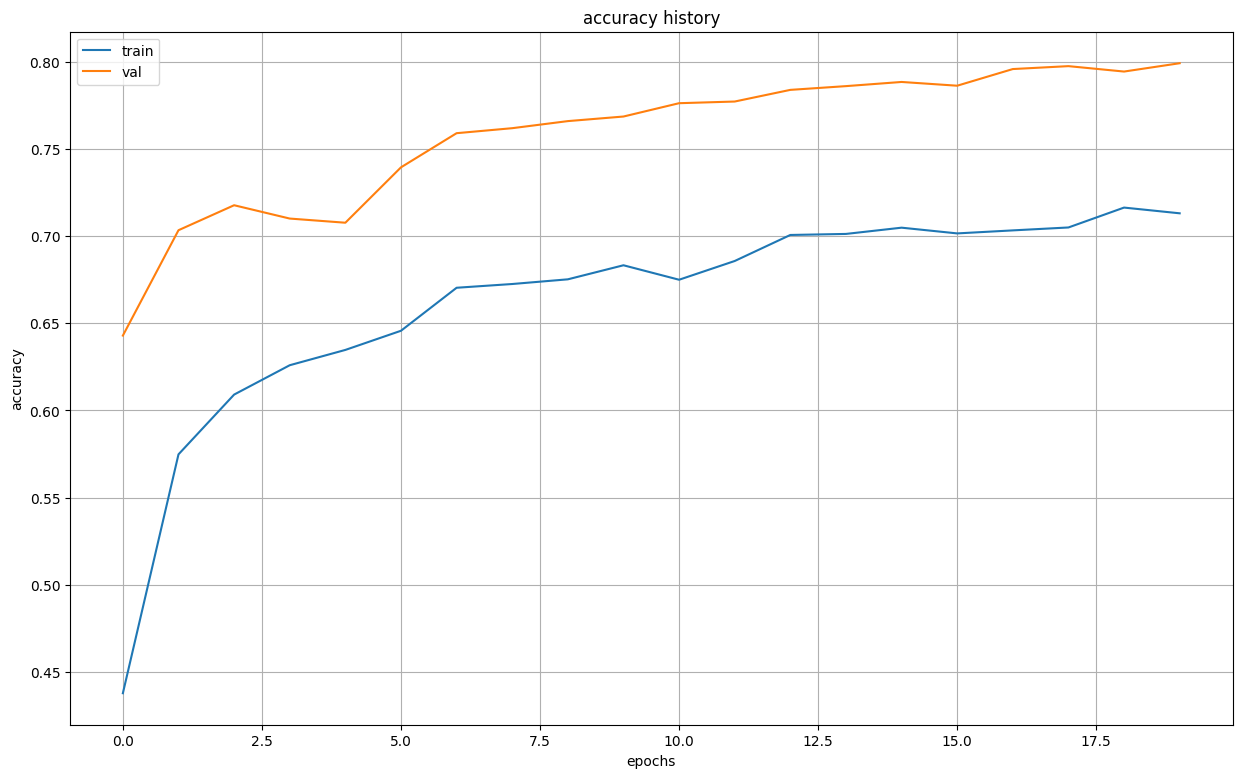

In [52]:
plot_history("loss", history_resnet)
plot_history("accuracy", history_resnet)

In [53]:
f1 = evaluate_f1(val_dataset, model_resnet50)
print(f'F1 = {f1:.4f}')

F1 = 0.8004


### ResNet with few freezed layers

In [28]:
model_resnet50_tuned = models.resnet50(weights='IMAGENET1K_V1')
layers_to_unfreeze = 5
    
layers = list(model_resnet50_tuned.children())
for layer in layers[:-layers_to_unfreeze]:
    for param in layer.parameters():
        param.requires_grad = False

num_features = model_resnet50.fc.in_features
model_resnet50_tuned.fc = torch.nn.Linear(num_features, n_classes)
model_resnet50_tuned = model_resnet50_tuned.to(DEVICE)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50_tuned.parameters(), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [30]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train', data_augmentation=True)

In [31]:
history_resnet_tuned = train(
    train_files=train_dataset,
    val_files=val_dataset,
    model=model_resnet50_tuned,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    epochs=20,
    batch_size=32
)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.104643557485423


epoch:   5%|▌         | 1/20 [01:26<27:28, 86.75s/it]


Epoch 001 train_loss: 1.1046     val_loss 0.2831 train_acc 0.7319 val_acc 0.9319
loss 0.807410466075513


epoch:  10%|█         | 2/20 [02:50<25:28, 84.94s/it]


Epoch 002 train_loss: 0.8074     val_loss 0.2872 train_acc 0.7918 val_acc 0.9291
loss 0.6078172554526152


epoch:  15%|█▌        | 3/20 [04:14<23:56, 84.48s/it]


Epoch 003 train_loss: 0.6078     val_loss 0.1864 train_acc 0.8417 val_acc 0.9570
loss 0.560314364064826


epoch:  20%|██        | 4/20 [05:37<22:25, 84.11s/it]


Epoch 004 train_loss: 0.5603     val_loss 0.1987 train_acc 0.8546 val_acc 0.9556
loss 0.4997996461622094


epoch:  25%|██▌       | 5/20 [07:01<20:57, 83.81s/it]


Epoch 005 train_loss: 0.4998     val_loss 0.1898 train_acc 0.8689 val_acc 0.9532
loss 0.5032042438963202


epoch:  30%|███       | 6/20 [08:24<19:33, 83.79s/it]


Epoch 006 train_loss: 0.5032     val_loss 0.1941 train_acc 0.8716 val_acc 0.9577
loss 0.47317642879702493


epoch:  35%|███▌      | 7/20 [09:48<18:07, 83.66s/it]


Epoch 007 train_loss: 0.4732     val_loss 0.1591 train_acc 0.8732 val_acc 0.9642
loss 0.3538995729170933


epoch:  40%|████      | 8/20 [11:12<16:45, 83.78s/it]


Epoch 008 train_loss: 0.3539     val_loss 0.1099 train_acc 0.9082 val_acc 0.9773
loss 0.35085733173928724


epoch:  45%|████▌     | 9/20 [12:35<15:20, 83.67s/it]


Epoch 009 train_loss: 0.3509     val_loss 0.1097 train_acc 0.9074 val_acc 0.9742
loss 0.34125650048462364


epoch:  50%|█████     | 10/20 [13:59<13:55, 83.59s/it]


Epoch 010 train_loss: 0.3413     val_loss 0.1124 train_acc 0.9097 val_acc 0.9747
loss 0.3247546716535923


epoch:  55%|█████▌    | 11/20 [15:22<12:32, 83.61s/it]


Epoch 011 train_loss: 0.3248     val_loss 0.1069 train_acc 0.9127 val_acc 0.9780
loss 0.3443336153537957


epoch:  60%|██████    | 12/20 [16:46<11:07, 83.47s/it]


Epoch 012 train_loss: 0.3443     val_loss 0.1067 train_acc 0.9086 val_acc 0.9749
loss 0.32027512912103584


epoch:  65%|██████▌   | 13/20 [18:09<09:45, 83.58s/it]


Epoch 013 train_loss: 0.3203     val_loss 0.1035 train_acc 0.9147 val_acc 0.9768
loss 0.3225811556454138


epoch:  70%|███████   | 14/20 [19:33<08:21, 83.58s/it]


Epoch 014 train_loss: 0.3226     val_loss 0.0969 train_acc 0.9145 val_acc 0.9768
loss 0.2597211469274032


epoch:  75%|███████▌  | 15/20 [20:56<06:57, 83.51s/it]


Epoch 015 train_loss: 0.2597     val_loss 0.0896 train_acc 0.9289 val_acc 0.9830
loss 0.26850179546106345


epoch:  80%|████████  | 16/20 [22:20<05:33, 83.44s/it]


Epoch 016 train_loss: 0.2685     val_loss 0.0852 train_acc 0.9286 val_acc 0.9814
loss 0.25618938753036785


epoch:  85%|████████▌ | 17/20 [23:44<04:10, 83.61s/it]


Epoch 017 train_loss: 0.2562     val_loss 0.0926 train_acc 0.9311 val_acc 0.9795
loss 0.252292199055538


epoch:  90%|█████████ | 18/20 [25:07<02:47, 83.62s/it]


Epoch 018 train_loss: 0.2523     val_loss 0.0876 train_acc 0.9315 val_acc 0.9816
loss 0.25718556461411074


epoch:  95%|█████████▌| 19/20 [26:31<01:23, 83.58s/it]


Epoch 019 train_loss: 0.2572     val_loss 0.0850 train_acc 0.9307 val_acc 0.9816
loss 0.25086308760012577


epoch: 100%|██████████| 20/20 [27:54<00:00, 83.74s/it]


Epoch 020 train_loss: 0.2509     val_loss 0.0930 train_acc 0.9330 val_acc 0.9811
Training complete in 27m 55s
Best val acc: 0.983043


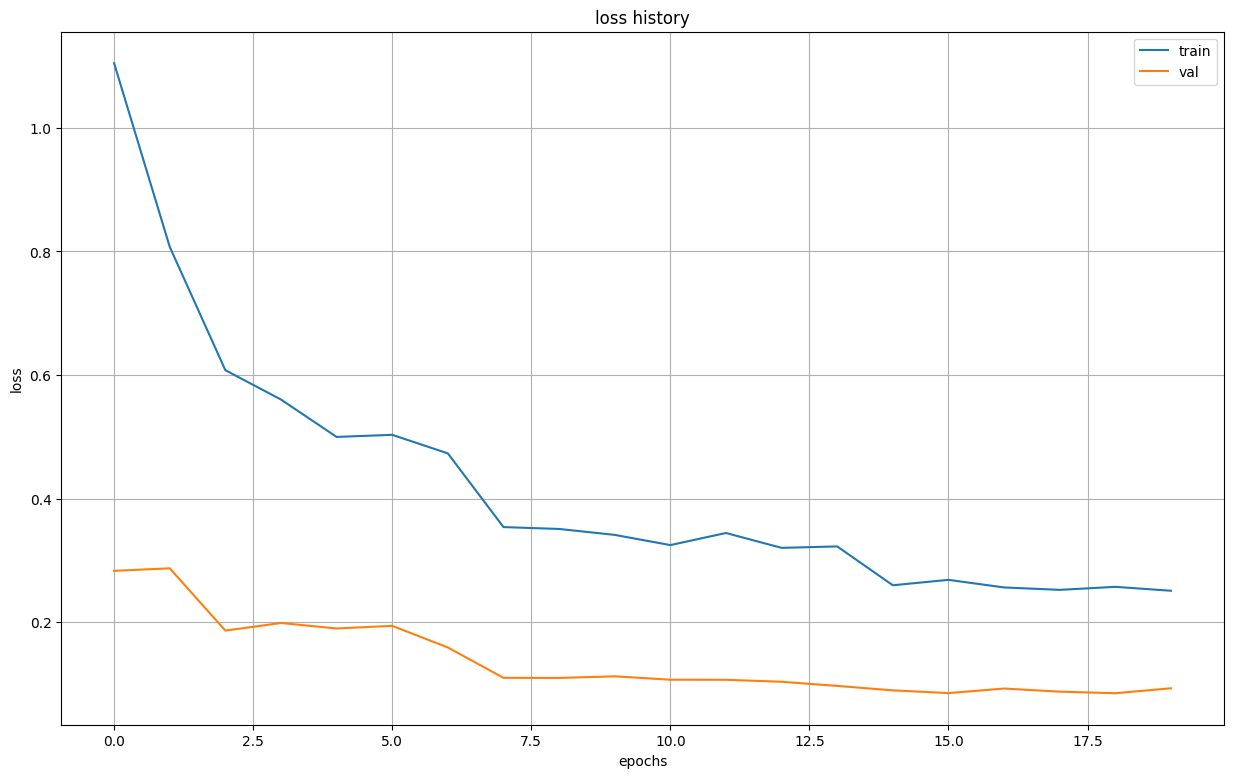

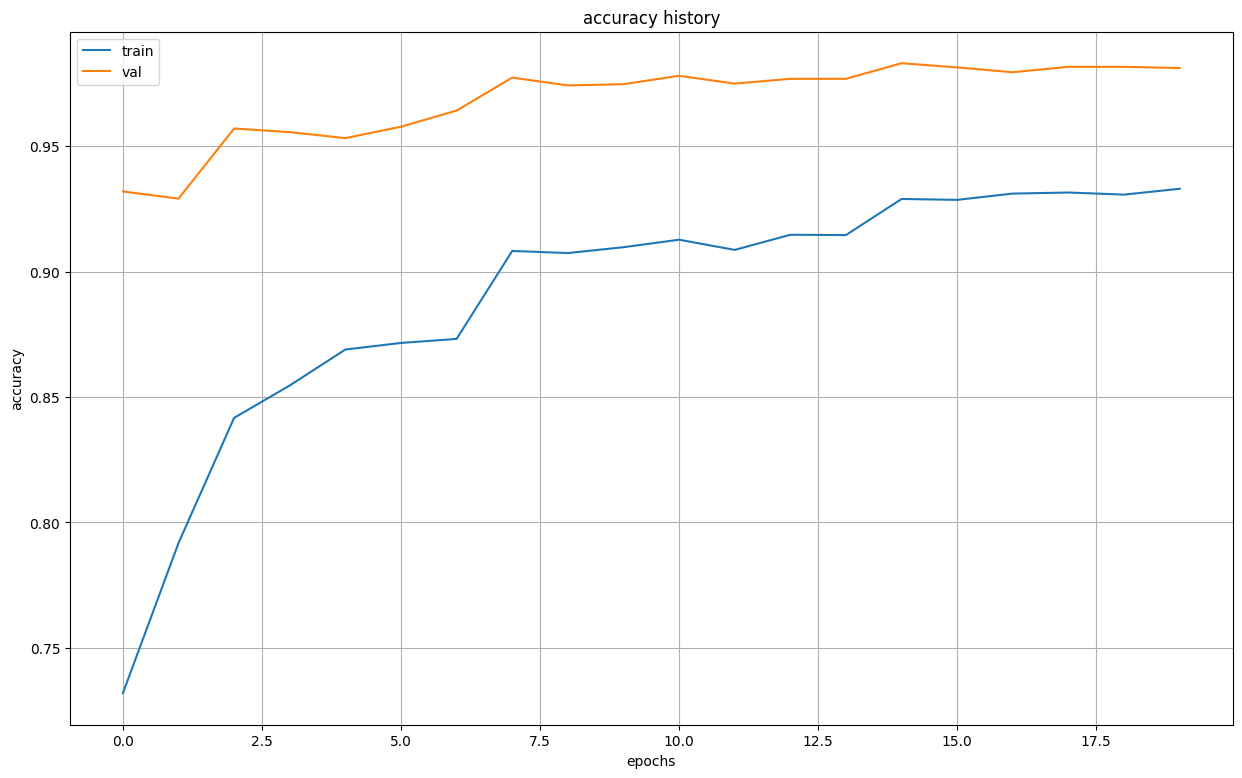

In [32]:
plot_history("loss", history_resnet_tuned)
plot_history("accuracy", history_resnet_tuned)

In [33]:
f1 = evaluate_f1(val_dataset, model_resnet50_tuned)
print(f'F1 = {f1:.4f}')

F1 = 0.9809


### Visualize misclassified images

In [42]:
idxs = range(len(val_dataset))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_resnet50_tuned, imgs)

y_pred = np.argmax(probs_ims, -1)
actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_class = [label_encoder.classes_[i] for i in actual_labels]

In [103]:
misclassified_idxs = np.array(actual_labels) != np.array(y_pred)
predicted_probs = np.max(probs_ims[misclassified_idxs], -1) * 100

misclassified_df = pd.DataFrame(
    list(
        zip(
             np.array(actual_class)[misclassified_idxs],
             np.array(preds_class)[misclassified_idxs], 
             predicted_probs, 
             np.where(misclassified_idxs)[0]
        )
    ),
    columns=['actual_class', 'pred_class', 'pred_probs', 'misclassified_idxs'])

misclassified_df = misclassified_df.sort_values('pred_probs', ascending=False).reset_index(drop=True)

misclassified_df

,actual_class,pred_class,pred_probs,misclassified_idxs
0,marge_simpson,lisa_simpson,100.000000,2597
1,barney_gumble,bart_simpson,99.999954,325
2,kent_brockman,nelson_muntz,99.989685,1820
3,agnes_skinner,principal_skinner,99.979027,184
4,professor_john_frink,principal_skinner,99.947388,3903
...,...,...,...,...
74,rainier_wolfcastle,moe_szyslak,24.329996,3913
75,martin_prince,milhouse_van_houten,23.804590,2699
76,ned_flanders,waylon_smithers,22.292427,3282
77,disco_stu,moe_szyslak,17.027096,1165


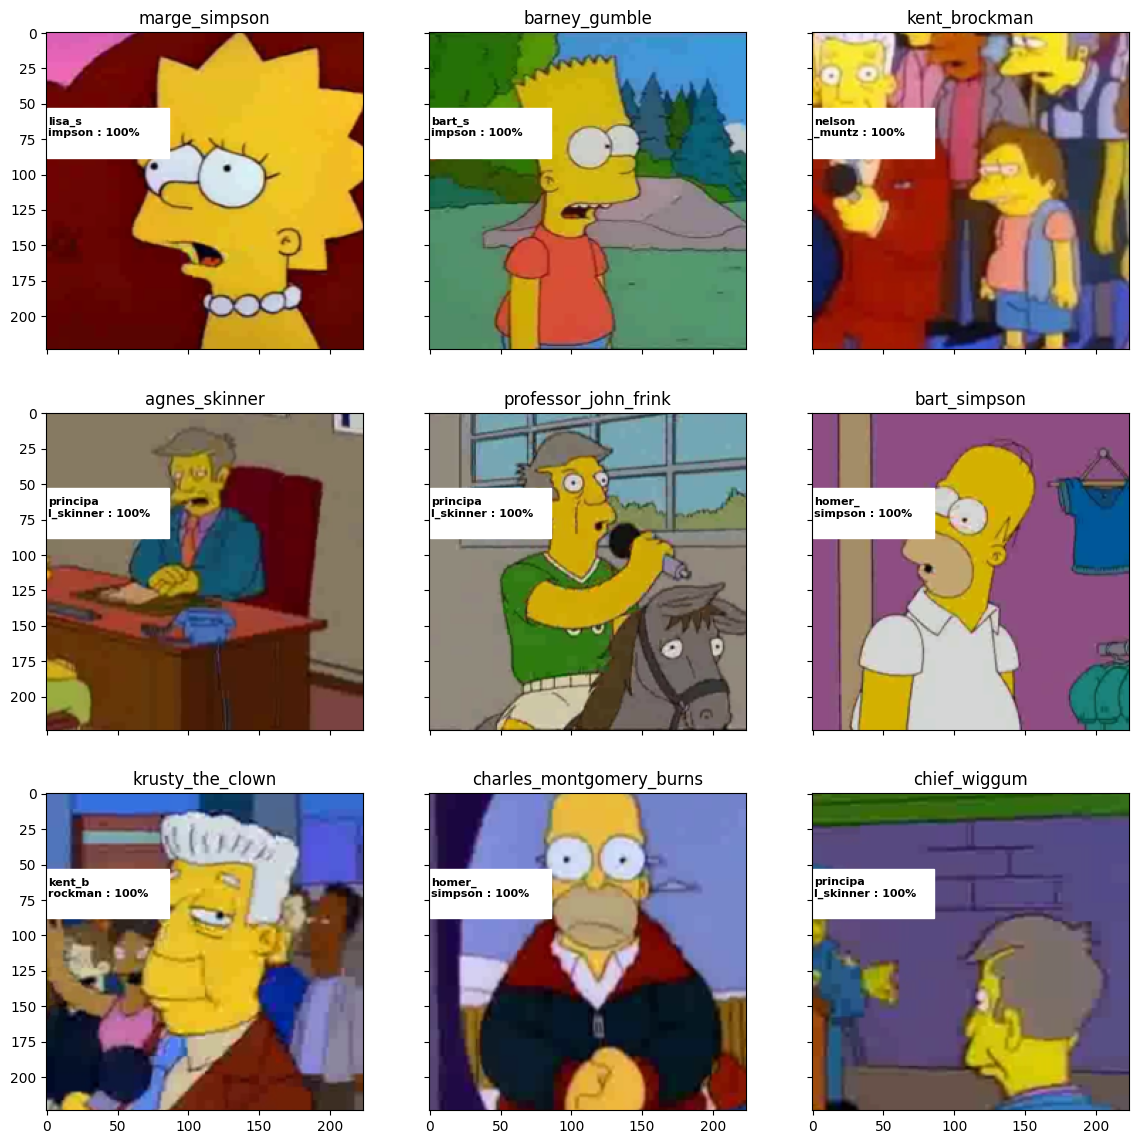

In [118]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(14, 14), \
                        sharey=True, sharex=True)
i = 0
for fig_x in ax.flatten():
    idxs_top9 = misclassified_df['misclassified_idxs'].values[:9][i]
    im_val, label = val_dataset[idxs_top9]
    actual_class_top9 = misclassified_df['actual_class'].values[:9][i]
    pred_class_top9 = misclassified_df['pred_class'].values[:9][i]
    imshow(im_val.data.cpu(), title = actual_class_top9 ,plt_ax = fig_x)
    
    actual_text = "Actual : {}".format(actual_class_top9)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    predicted_proba_top9 = misclassified_df['pred_probs'].values[:9][i]

    predicted_label = pred_class_top9
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba_top9)

    i += 1
    fig_x.text(1, 59, predicted_text , horizontalalignment = 'left', fontproperties = font,
                    verticalalignment = 'top',fontsize=8, color = 'black',fontweight = 'bold')

### Submit the best results

In [119]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet50_tuned, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [120]:
! ls

journey-springfield  journey-springfield.zip  label_encoder.pkl


In [121]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [122]:
my_submit.to_csv('model_resnet50_tuned.csv', index=False)